<a href="https://colab.research.google.com/github/ghkdwnwsdud/AI-Project/blob/main/RNN_2024_week4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Before we start, <font color='red'> PLEASE write your answers at below answer cells  </font> for all questions. <br>
Detailed about questions will be found as you go through the lecture. <br>



###**Answer for question 1 (1point):**

- Write answer to fill blank OO in line 18.    

    A: 14

- Write answer to fill blank OO in line 22.

    A: 20


###**Answer for question 2 (1point):**

* Complete the rnn code using one hot encoding below.
<br>
    A:

In [ ]:
'''
class RNN_model(torch.nn.Module):
  def __init__(self, vocab_size, input_size, hidden_size):
    super(RNN_model, self).__init__()
    self.vocab_size = vocab_size
    self.input_size = input_size
    self.hidden_size = hidden_size
    #Embedding layer
    self.embedding_layer = torch.nn.Linear(vocab_size, input_size)
    #RNN layer
    self.rnn_layer = torch.nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=2, batch_first=True)
    #linear layer
    self.linear = torch.nn.Linear(hidden_size, vocab_size)
  def forward(self, x):
    #Embedding layer
    y = self.embedding_layer(x.to(torch.float))
    #RNN layer
    y, hidden = self.rnn_layer(y)
    #linear layer
    y = self.linear(y)
    return y
'''

###**Answer for question 3 (1point):**
*  Why do you think LSTM use tanh? <br>
A: tanh 함수는 비선형 함수이기 때문에 input에 대한 비선형 activation을 제공하고, input을 -1에서 1사이의 값으로 스케일링 해서 input값을 정규화하고 네트워크의 안정성을 향상시키기 때문이다.
<br>
*  Provide an example scenario where an LSTM would be more appropriate than a basic RNN. <br>
A: 문장이나 문서와 같은 긴 텍스트 시퀀스 학습, 음악 생성(긴 음악 조각에서 음악적인 구조를 학습하고 다음 음표를 예측), 이미지 캡셔닝과 같은 곳에서 LSTM이 더 적합할 수 있다. (LSTM은 basic RNN의 단점을 보완하고 장기 의존성을 모델링하는 데에 특히 유용하기 때문)

###**Answer for question 4 (1point):**
- Write your code for update_gate function.
    
    A:


In [ ]:
'''
class GRU_custom(torch.nn.Module):
    """
    A simple GRU cell network for educational purposes
    """

    def __init__(self, input_dim=10, hidden_dim=20):
        super(GRU_custom, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        #reset
        self.linear_reset_w1 = nn.Linear(self.input_dim, self.hidden_dim, bias=True)
        self.linear_reset_r1 = nn.Linear(self.hidden_dim, self.hidden_dim, bias=True)

        self.linear_reset_w2 = nn.Linear(self.input_dim, self.hidden_dim, bias=True)
        self.linear_reset_r2 = nn.Linear(self.hidden_dim, self.hidden_dim, bias=True)
        self.sigmoid = nn.Sigmoid()

        #update
        self.linear_gate_w3 = nn.Linear(self.input_dim, self.hidden_dim, bias=True)
        self.linear_gate_r3 = nn.Linear(self.hidden_dim, self.hidden_dim, bias=True)
        self.tanh = nn.Tanh()

    def reset_gate(self, x, h):
        x_1 = self.linear_reset_w1(x)
        h_1 = self.linear_reset_r1(h)
        # gate update
        reset = self.sigmoid(x_1 + h_1)

        return reset

    def update_gate(self, x, h):
        x_2 = self.linear_reset_w2(x)
        h_2 = self.linear_reset_r2(h)
        z = self.sigmoid(h_2 + x_2)

        return z

    def update_component(self, x, h, r):
        x_3 = self.linear_gate_w3(x)
        h_3 = r * self.linear_gate_r3(h)
        gate_update = self.tanh(x_3 + h_3)

        return gate_update

    def forward(self, x, h):
        # Equation 1. reset gate vector
        r = self.reset_gate(x, h)

        # Equation 2: the update gate - the shared update gate vector z
        z = self.update_gate(x, h)

        # Equation 3: The almost output component
        n = self.update_component(x, h, r)

        # Equation 4: the new hidden state
        h_new = (1 - z) * n + z * h


        return h_new
'''

#**Tutorial 6: RNN**

**Course Title**: AI project (SWE3032-41)

**Acknowledgement** This tutorial is based on the book "PyTorch로 시작하는 딥 러닝 입문" and theaisummer's github.

Welcome to our Recurrent Neural Network tutorial. The following notebook is meant to give an experience of coding on RNN and following topics including naive RNN, LSTM, and GRU.

**Why use RNN?** RNN can handle various tasks (Next step prediction, Classification, Sequence Generation) by using sequential data(Speech, Text, Image).

**There are 4 types of processes:**

![](https://drive.google.com/uc?export=view&id=1MWoJvRqvvpGLdy3ngMYEbOJCtaVWY9dp)

**Today, we implement below models**

1. Text generation.
2. Signal prediction.

We will use a set of standard libraries, which you have already been using throughout previous lectures.

In [1]:
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import random
import torch
import math
import random
import warnings
warnings.filterwarnings(action='ignore')

**Set SEED**

Below code is to set seed for code. I recommend you to set seed for your project for stable result. However, try not to use "torch.backends.cudnn.deterministic" function from the start because it may slow down calculation.



In [2]:
seed = 2024
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
# torch.backends.cudnn.deterministic = True
# seed를 고정해주는 것이 좀 더 안전하게 결과를 낼 수 있음

##**1. Word-RNN(Recurrent Neural Network)**

####Let's implement RNN to text generation!

Task: Sequential Generation

Data: Text

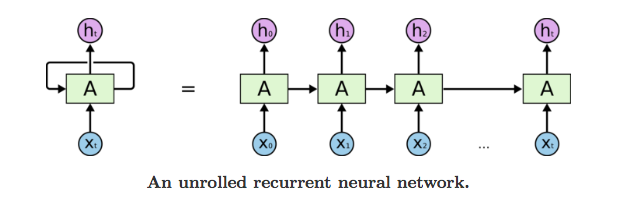

First step to everthing is always data preprocessing!

Note this tutorial don't go through natural language's preprocessing steps such as lemmatization for I wil be using a simple sentence written in standard english. Try tutorial [lemmatization](https://wikidocs.net/21707) if you are not familiar with natural language. Also here is torchtext preprocessing tutorial [Torchtext preprocesing](https://wikidocs.net/60314) could be useful.

###**1-1. Data preprocessing**

Let's use simple sentence from the movie "Lion King" as a data. Tokenize manually by using set function.

In [3]:
sentence = "The past can hurt, but you can either run from it, or learn from it".split() # 과거는 아플 수 있어, 하지만 과거로부터 도망갈 수도 있고 배울 수도 있어 - 라이온킹 명대사
#Make a vokabulary list
vocab = list(set(sentence))
print(vocab)

['hurt,', 'but', 'it', 'it,', 'from', 'either', 'can', 'past', 'you', 'run', 'or', 'learn', 'The']


To use word indexing, create word2index dictionary transfroms that translates word to an index(number).
Will be using this dictionary when creating input for the model.

We also create index2word dictionary by reversing key&value of a word2index dictionary. Will be using this dictionary when converting outcome of a model to natural language.





In [4]:
word2index = {tkn: i for i, tkn in enumerate(vocab, 1)}
word2index['<unk>']=0
print(word2index)
# computer가 받아들일 수 있도록 단어들을 숫자 형태로 입력줌

{'hurt,': 1, 'but': 2, 'it': 3, 'it,': 4, 'from': 5, 'either': 6, 'can': 7, 'past': 8, 'you': 9, 'run': 10, 'or': 11, 'learn': 12, 'The': 13, '<unk>': 0}


In [5]:
#This dict transfroms index to number(number)
index2word = {v: k for k, v in word2index.items()}
print(index2word)

{1: 'hurt,', 2: 'but', 3: 'it', 4: 'it,', 5: 'from', 6: 'either', 7: 'can', 8: 'past', 9: 'you', 10: 'run', 11: 'or', 12: 'learn', 13: 'The', 0: '<unk>'}


Next step is to slice the sentence into input data(x) and label(y).

let's print x and y and see the result. Notice x is from index 0 to one before the last index and label is from index 1 to the last index.

In [6]:
#Function to make the input data(X) and the labels(Y)
def build_data(sentence, word2index):
  encoded = [word2index[token] for token in sentence] # transforms word to index
  input_seq, label_seq = encoded[:-1], encoded[1:] # Split the input sequence and label sequence
  input_seq = torch.LongTensor(input_seq).unsqueeze(0)
  label_seq = torch.LongTensor(label_seq).unsqueeze(0)
  return input_seq, label_seq, encoded

In [7]:
x, y, encoded = build_data(sentence, word2index)

In [8]:
print(f'sentence: "The past can hurt, but you can either run from it, or learn from it" \nencoded {encoded} \nInput data: {x} \nlabes: {y}')
# The ~ from -> input data
# past ~ it -> prediction

sentence: "The past can hurt, but you can either run from it, or learn from it" 
encoded [13, 8, 7, 1, 2, 9, 7, 6, 10, 5, 4, 11, 12, 5, 3] 
Input data: tensor([[13,  8,  7,  1,  2,  9,  7,  6, 10,  5,  4, 11, 12,  5]]) 
labes: tensor([[ 8,  7,  1,  2,  9,  7,  6, 10,  5,  4, 11, 12,  5,  3]])


####**Word Embedding**

In order to handle **text** data, a process of changing word to a numeric value is required. We will give embedding dimension as 5.

In [9]:
embedding_function = torch.nn.Embedding(num_embeddings=len(word2index), embedding_dim = 5)
embedding_function(x)
# 14개 단어에 대한 5차원 embedding

tensor([[[-0.2561,  0.1192,  0.2987, -2.2808, -0.8726],
         [ 0.8273,  0.4594,  0.3922, -1.0767, -0.0576],
         [ 0.0498,  1.2883, -0.6491, -0.8969,  1.2634],
         [-0.2610,  0.6230, -1.1561,  0.1171, -1.8865],
         [ 2.1822, -0.1930,  0.5358, -0.8898, -0.3099],
         [-0.0596,  0.2764, -0.2403,  0.7203, -1.4108],
         [ 0.0498,  1.2883, -0.6491, -0.8969,  1.2634],
         [ 1.4148,  0.6343,  2.7266, -1.4753, -1.4808],
         [-0.4384,  0.3551,  0.3730, -1.3050,  0.0984],
         [-0.0421,  1.6579, -1.3085,  0.9962,  0.9391],
         [ 1.8567,  1.9776, -0.4322,  1.3667,  0.8432],
         [-0.1520, -1.8187, -1.0217, -0.8227,  0.5490],
         [-0.9570, -0.1175, -0.3248,  1.3998, -0.5299],
         [-0.0421,  1.6579, -1.3085,  0.9962,  0.9391]]],
       grad_fn=<EmbeddingBackward0>)

###**1-2. Implenment the Many-to-Many RNN model**
We will give multiple inputs and get multiple outputs sequentially.

 First word "life" will be given at time *t* as an input. Then at time *t+1*, hidden representation of "life" and "is" will be given to RNN layer to create outcome. At the last step, softmax will give probability and create loss by utilising cross entropy.

![](https://drive.google.com/uc?export=view&id=1YWWGMXlsX-7vlsDtMv7tgNQxJOG1R9kx)


Set hyperparameters. These values are yet to go tuning. Try grid search you have learned to improve test score!

In [10]:
#hyper parameter
vocab_size = len(word2index) # 14
input_size = 5 # embbeding dim
hidden_size = 20 # hidden size of RNN layer
epochs = 200

Below is code for the RNN model. Notice it has same structure with other models (made of init and forward function). Take time to go through the code and dimensions of outcomes.

Please visit official docuement [torch.nn.RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html)  to find out more about rnn layer.

#### <font color='red'> Question1: Fill in OO.</font>

There are two OOs. line 18 and line 22. Calculate the **dimension** and fill in OOs. You have used at the answer cell.

In [11]:
class RNN_model(torch.nn.Module):
  #vocab_size = size of the using word 14 (decided from original text)
  #hidden_size = size of the RNN's output 20 (hyper-parameter)
  #input size = size of input embedding 5 (decided from previous cell)
  def __init__(self, vocab_size, input_size, hidden_size):
    super(RNN_model, self).__init__()
    #Embedding layer
    self.embedding_layer = torch.nn.Embedding(num_embeddings=vocab_size,embedding_dim=input_size) # give embedding for each word
    #RNN layer
    self.rnn_layer = torch.nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=True) # RNN(5, 20)  # input size인 5차원으로 들어오고 그것을 20차원으로 출력
    #linear layer                                                                                                               # num_layers = 1 은 RNN layer를 1단만 쌓는다
    self.linear = torch.nn.Linear(hidden_size, vocab_size) # Linear(in_features=20, out_features=14, bias=True)
  def forward(self, x):
    #1. Embedding layer
    #size of the data: (batch_size, length of the sequence) -> (batch_size, lenth of the sequence, dimension of embedding)
    y = self.embedding_layer(x)
    # x: tensor([[10,  1,  3, 11,  2, 12,  3,  8,  4,  5,  7,  9,  6,  5]]) torch.Size([1, 14])
    # QUESTION y: torch.Size([1, OO, 5])
    #2. RNN layer
    #size of the data: (batch_size, length of the sequence, embedding dimension) -> y: (batch_size, length of the sequence, hidden_size), hidden: (num_layer, batch_size, hidden_size)
    y, hidden = self.rnn_layer(y)
    # QUESTION y: torch.Size([1, 14, 20]) hidden: torch.Size([1, 1, OO])

    #3. Linear layer
    #size of the data: (batch_size, length of the sequence, hidden_size) -> (batch_size, length of the sequence, vocab_size)
    y = self.linear(y)
    # y: torch.Size([1, 14, 14])

    #Size of the return value: (batch_size*lenth of the sequence, vocab_size)
    return y.view(-1, y.size(2)) # torch.Size([14, 14])

###1-3. Train the RNN model

This is the final step. If the result is not satisfactory, try change hyperparameters.

In [12]:
model = RNN_model(vocab_size, input_size, hidden_size)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters())

This is the function to decode the model result into word.

In [13]:
decode = lambda y: [index2word.get(x) for x in y]

Let's see the output of the model before training. How bad is it?

In [14]:
output = model(x)
pred = output.softmax(-1).argmax(-1).tolist()

print(f'The past can hurt, but you can either run from it, or learn from it')
print(f'Result of the rnn model: {" ".join(decode(pred))}')

The past can hurt, but you can either run from it, or learn from it
Result of the rnn model: but from The hurt, from hurt, from from from from but either from from


Check out the difference training makes!

In [15]:
#Training
print(f'The past can hurt, but you can either run from it, or learn from it')
for epoch in range(1, epochs+1):
    optimizer.zero_grad()
    output = model(x)
    loss = loss_function(output, y.view(-1))
    loss.backward()
    optimizer.step()
    # Observe the result
    if epoch % 20 == 0:
        print(f"Epoch: {epoch}, Loss: {loss}")
        pred = output.softmax(-1).argmax(-1).tolist()
        print(" ".join(['The']+ decode(pred)))
        print()

The past can hurt, but you can either run from it, or learn from it
Epoch: 20, Loss: 2.4002482891082764
The but from hurt, hurt, from hurt, either from from it, but either from from

Epoch: 40, Loss: 2.1556859016418457
The but can hurt, but from hurt, either run from it, but either from from

Epoch: 60, Loss: 1.8736597299575806
The past can hurt, but from from either run from it, or learn from it,

Epoch: 80, Loss: 1.5564717054367065
The past can hurt, but you can either run from it, or learn from it

Epoch: 100, Loss: 1.2348346710205078
The past can hurt, but you can either run from it, or learn from it

Epoch: 120, Loss: 0.9428297281265259
The past can hurt, but you can either run from it, or learn from it

Epoch: 140, Loss: 0.7027629613876343
The past can hurt, but you can either run from it, or learn from it

Epoch: 160, Loss: 0.5237537026405334
The past can hurt, but you can either run from it, or learn from it

Epoch: 180, Loss: 0.3976508677005768
The past can hurt, but you can e

Let's learn about One hot encoding. One hot encoding is a process of converting categorical data variables so they can be provided to machine learning algorithms to improve predictions. On the previous example, we used label encoding. Below is an example of an one-hot encoding.

![](https://drive.google.com/uc?export=view&id=1olIzP1hy6euCkswbCoR3iSHWqa7KI6JR)


![image.png](https://miro.medium.com/v2/resize:fit:750/1*NuWIU2Iew3Bm8NR78tRj8A.png)

Below is a code for one hot encoding.

As you can see, word "you" has index 14 and thus the corresponding one hot vector is [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]. Only has "1" at index 12

In [16]:
def one_hot_encoding(word, word_to_index):
  one_hot_vector = [0]*(len(word_to_index))
  index = word_to_index[word]
  one_hot_vector[index] = 1
  return one_hot_vector
print('word to index dictionary', word2index)
print('one hot encoding of word "you":',one_hot_encoding('you', word2index))

word to index dictionary {'hurt,': 1, 'but': 2, 'it': 3, 'it,': 4, 'from': 5, 'either': 6, 'can': 7, 'past': 8, 'you': 9, 'run': 10, 'or': 11, 'learn': 12, 'The': 13, '<unk>': 0}
one hot encoding of word "you": [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]


#### <font color='red'> Question2: Implement one hot encoding.</font>

**Complete the rnn code** using one hot encoding below.

In [17]:
def one_hot_encoding(sentence, word2index):
    encoded = torch.zeros(len(sentence), len(word2index))
    for idx, word in enumerate(sentence):
        word_index = word2index[word]
        encoded[idx][word_index] = torch.LongTensor([1])
    input_seq, label_seq = encoded[:-1], encoded[1:] # Split the input sequence and label sequence
    return input_seq.to(torch.long), label_seq.to(torch.long), encoded.to(torch.long)
x, y, encoded = one_hot_encoding(sentence, word2index)
print(f"x{x}, \ny{y}, \nencoded{encoded}")

xtensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]]), 
ytensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       

In [18]:
#hyper parameter
vocab_size = len(word2index) # 16
input_size = 5 # embbeding dim
hidden_size = 20 # hidden size of RNN layer
epochs = 200
class RNN_model(torch.nn.Module):
  def __init__(self, vocab_size, input_size, hidden_size):
    super(RNN_model, self).__init__()
    self.vocab_size = vocab_size
    self.input_size = input_size
    self.hidden_size = hidden_size
    #Embedding layer  (어떻게 onehot encoding에서 우리가 원하는 사이즈로 바꿔줄지 구현)
                        #one-hot -> embedding
                        #14차원  -> 5차원
    self.embedding_layer = torch.nn.Linear(vocab_size, input_size)
    #RNN layer
    self.rnn_layer = torch.nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=2, batch_first=True)
    #linear layer
    self.linear = torch.nn.Linear(hidden_size, vocab_size)
  def forward(self, x):
    #Embedding layer
    y = self.embedding_layer(x.to(torch.float))
    #RNN layer
    y, hidden = self.rnn_layer(y)
    #linear layer
    y = self.linear(y)
    return y

model = RNN_model(vocab_size, input_size, hidden_size)

loss_function = torch.nn.MSELoss() # write which loss fuction you have used.

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
print(f'The past can hurt, but you can either run from it, or learn from it')
for epoch in range(1, epochs+1):
    optimizer.zero_grad()
    output = model(x)
    loss = loss_function(output, y.float())
    loss.backward()
    optimizer.step()
    # Observe the result
    if epoch % 20 == 0:
        # print(model.linear.weight[0])
        print(f"Epoch: {epoch}, Loss: {loss}")
        pred = output.argmax(-1).tolist()
        print(" ".join(['The']+ decode(pred)))

The past can hurt, but you can either run from it, or learn from it
Epoch: 20, Loss: 0.03455885499715805
The past can hurt, but you can hurt, run from it, or learn from it
Epoch: 40, Loss: 0.010554044507443905
The past can hurt, but you can either run from it, or learn from it
Epoch: 60, Loss: 0.0011275137076154351
The past can hurt, but you can either run from it, or learn from it
Epoch: 80, Loss: 0.00013059278717264533
The past can hurt, but you can either run from it, or learn from it
Epoch: 100, Loss: 1.5392031855299138e-05
The past can hurt, but you can either run from it, or learn from it
Epoch: 120, Loss: 1.926644245031639e-06
The past can hurt, but you can either run from it, or learn from it
Epoch: 140, Loss: 2.575535802407103e-07
The past can hurt, but you can either run from it, or learn from it
Epoch: 160, Loss: 3.6705131378766964e-08
The past can hurt, but you can either run from it, or learn from it
Epoch: 180, Loss: 4.373813755620404e-09
The past can hurt, but you can ei

##2. Signal prediction by using LSTM
RNN is a powerful tool but has few major problems. One of which is a long term dependency.

**HOW to deal with long term dependency (gradient vanishing issue)?**
can be answered by lstm. Through this tutorial, we will look at lstm code and try writing GRU code.

Make sure you are using GPU. This tutorial takes long time to train.


In [19]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using device:", DEVICE)

Using device: cuda


###2-1. Generate synthetic data.

Let's create a sin wave.

In [20]:
def generate_synthetic_data(freqs=[1.0], ampls=[1.0], T=500, L=501, N=1):
    """
    Generate synthetic sin wave data.
    Args:
    - freqs (list): List of frequencies for the sine waves.
    - ampls (list): List of amplitudes for the sine waves. Must be the same length as freqs.
    - T (int): A scaling factor.
    - L (int): Length of the sine wave.
    - N (int): Number of sine waves.

    Returns:
    - data (torch.Tensor): The generated sine wave data of shape (N, L).
    """
    if len(freqs) != len(ampls):
        raise ValueError("Length of freqs and ampls must be the same")

    x = torch.linspace(0, T, L, dtype=torch.float64).unsqueeze(0).repeat(N, 1)
    data = torch.zeros(N, L, dtype=torch.float64)

    for freq, amp in zip(freqs, ampls):
        data += amp * torch.sin(freq * x)

    return data
data = generate_synthetic_data()
torch.save(data, 'syntheticdata.pt')


Let's see how the data looks like.

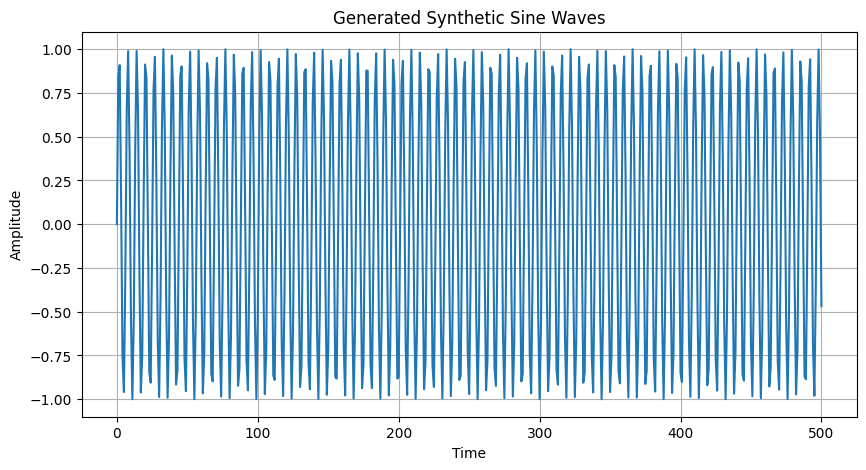

In [21]:
plt.figure(figsize=(10, 5))
for i in range(data.shape[0]):
    plt.plot(data[i].detach().cpu().numpy(), label=f'Sine wave {i+1}')
plt.title("Generated Synthetic Sine Waves")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

Here is a simple model code.

In [22]:

class DependencyModel(nn.Module):
    def __init__(self, USE_LSTM=True, USE_CUSTOM=True):
        super(DependencyModel, self).__init__()
        self.LSTM = USE_LSTM
        if USE_LSTM:
            if USE_CUSTOM:
                print("Using custom LSTM model.")
                self.rnn1 = LSTM_custom(1, 151)
                self.rnn2 = LSTM_custom(151, 151)
            else:
                print("Using official PyTorch LSTM cell implementation...")
                self.rnn1 = nn.LSTMCell(1, 151)
                self.rnn2 = nn.LSTMCell(151, 151)
        # GRU
        else:
            if USE_CUSTOM:
                print("Using custom GRU model..")
                self.rnn1 = GRU_custom(1, 151)
                self.rnn2 = GRU_custom(151, 151)
            else:
                print("Using official PyTorch GRU cell implementation...")
                self.rnn1 = nn.GRUCell(1, 151)
                self.rnn2 = nn.GRUCell(151, 151)

        self.linear = nn.Linear(151, 1)       #151차원을 1차원으로 다시 줄여줌 (sin 파동은 1차원)

    def forward(self, input, future=0):
        outputs = []
        h_t = torch.zeros(input.size(0), 151, dtype=torch.float64).to('cuda')
        c_t = torch.zeros(input.size(0), 151, dtype=torch.float64).to('cuda')
        h_t2 = torch.zeros(input.size(0), 151, dtype=torch.float64).to('cuda')
        c_t2 = torch.zeros(input.size(0), 151, dtype=torch.float64).to('cuda')

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)): # input을 하나씩 넣기
            if self.LSTM:
                h_t, c_t = self.rnn1(input_t, (h_t, c_t))
                h_t2, c_t2 = self.rnn2(h_t, (h_t2, c_t2))
            else:
                h_t = self.rnn1(input_t, h_t)
                h_t2 = self.rnn2(h_t, h_t2)

            output = self.linear(h_t2)
            outputs += [output]
        # if we should predict the future
        for i in range(future):
            if self.LSTM:           #hidden state 2개
                h_t, c_t = self.rnn1(input_t, (h_t, c_t))
                h_t2, c_t2 = self.rnn2(h_t, (h_t2, c_t2))
            else:                   #hidden state 1개
                h_t = self.rnn1(input_t, h_t)
                h_t2 = self.rnn2(h_t, h_t2)
            output = self.linear(h_t2)
            outputs += [output]
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

Let's run this code, see what it does. Below code trains the synthetic sine data and create the next 5 second's sine wave. Click on "predicted.png" file to check out its outcome.

In [23]:
data = torch.load('syntheticdata.pt').to('cuda')
input = data[0:1, 0:100].to('cuda')
target = data[0:1, 5:105].to('cuda')
test_input = data[0:1, 105:205].to('cuda')
test_target = data[0:1, 110:210].to('cuda')

seq = DependencyModel(USE_LSTM=True, USE_CUSTOM=False).to('cuda')

seq.double()
criterion = nn.MSELoss()
optimizer = optim.Adam(seq.parameters(), lr=0.01, weight_decay= 1.5e-03)
# begin to train
for i in range(200):
    def closure():
        optimizer.zero_grad()
        out = seq(input)
        loss = criterion(out, target)
        print('loss:', loss.item())
        loss.backward()
        return loss
    optimizer.step(closure)
    with torch.no_grad():
        future = 5
        pred = seq(test_input, future=future)
        loss = criterion(pred[:, :-future], test_target)
        y = pred.detach().cpu().numpy()

Using official PyTorch LSTM cell implementation...
loss: 0.49853251509746016
loss: 0.49326439895829655
loss: 0.45136991134165966
loss: 0.4168893982908
loss: 0.3445702077166062
loss: 0.24357400247995414
loss: 0.09645170196323612
loss: 0.05704247426938766
loss: 0.15338460385576635
loss: 0.0294431342335532
loss: 0.026106851565838207
loss: 0.059120158228136654
loss: 0.06934987332236252
loss: 0.05917672063109425
loss: 0.0444490963910613
loss: 0.02970077137325465
loss: 0.02795911246815041
loss: 0.025510519867713306
loss: 0.02869490852015612
loss: 0.03095027212228333
loss: 0.01788159626125424
loss: 0.01646754014225329
loss: 0.02160000561524906
loss: 0.028194981443845784
loss: 0.029364661586574012
loss: 0.021426252885476952
loss: 0.01421336572349306
loss: 0.010465570795932019
loss: 0.01542652822588227
loss: 0.0133831091590439
loss: 0.011516068605239085
loss: 0.009970835940639963
loss: 0.011038700550626905
loss: 0.013581290812035733
loss: 0.01417563865923288
loss: 0.013520476175277657
loss: 0.0

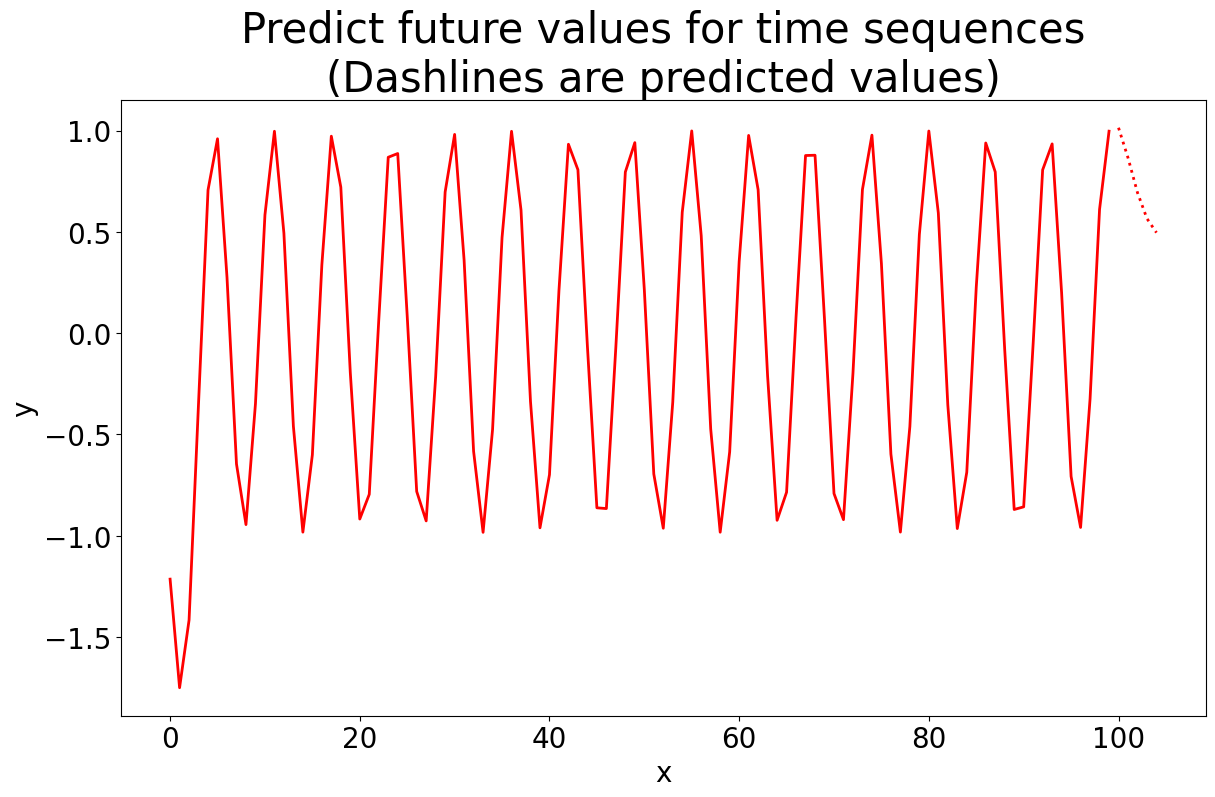

In [24]:
# draw the result
plt.figure(figsize=(14, 8))
plt.title('Predict future values for time sequences\n(Dashlines are predicted values)', fontsize=30)
plt.xlabel('x', fontsize=20)
plt.ylabel('y', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


def draw(yi, color):
    plt.plot(np.arange(input.size(1)), yi[:input.size(1)], color, linewidth=2.0)
    plt.plot(np.arange(input.size(1), input.size(1) + future), yi[input.size(1):], color + ':', linewidth=2.0)

draw(y[0], 'r')
plt.show()
# plt.savefig('predicted.png')
# plt.close()

#### <font color='red'>Question 3: Answer questions below</font>
write your answers at the top of the colab file. <br>
Q: Why do you think LSTM use tanh?

Q: Provide an example scenario where an LSTM would be more appropriate than a basic RNN.

hint1: <font color='white'>Think of 1. What happens to gradient? 2. Can sigmoid decrease value?</font>

hint2: <font color='white'> What is C doing in LSTM? </font>


###2-2. Implement LSTM model and Train that model
In this section, we will take a look at LSTM implementation.
![](https://drive.google.com/uc?export=view&id=1aMPDNrdC5WWp9l5DN_mD86rjYN_xJKC0)


In [25]:
class LSTM_custom(torch.nn.Module):
    def __init__(self, input_length=10, hidden_length=20):
        super(LSTM_custom, self).__init__()
        self.input_length = input_length
        self.hidden_length = hidden_length
        # forget gate components      (f gate: 어떤 정볼르 잊을지)
        self.linear_forget_w1 = nn.Linear(self.input_length, self.hidden_length, bias=True)
        self.linear_forget_r1 = nn.Linear(self.hidden_length, self.hidden_length, bias=False)
        self.sigmoid = nn.Sigmoid()
        # input gate components       (i gate (f gate와 같은 구조를 띰))
        self.linear_gate_w2 = nn.Linear(self.input_length, self.hidden_length, bias=True)
        self.linear_gate_r2 = nn.Linear(self.hidden_length, self.hidden_length, bias=False)
        # cell memory components      (c (f, i, g에서의 output들을 연산해줌))
        self.linear_gate_w3 = nn.Linear(self.input_length, self.hidden_length, bias=True)
        self.linear_gate_r3 = nn.Linear(self.hidden_length, self.hidden_length, bias=False)
        self.linear_gate_c1 = nn.Linear(self.hidden_length, self.hidden_length, bias=False)
        self.tanh = nn.Tanh()
        # out gate components
        self.linear_gate_w4 = nn.Linear(self.input_length, self.hidden_length, bias=True)
        self.linear_gate_r4 = nn.Linear(self.hidden_length, self.hidden_length, bias=False)

    def forget(self, x, h):
        x = self.linear_forget_w1(x)
        h = self.linear_forget_r1(h)
        return self.sigmoid(x + h)

    def input_gate(self, x, h):
        x_temp = self.linear_gate_w2(x)
        h_temp = self.linear_gate_r2(h)
        i = self.sigmoid(x_temp + h_temp)
        return i

    def cell_memory_gate(self, i, f, x, h, c_prev):
        x = self.linear_gate_w3(x)
        h = self.linear_gate_r3(h)

        k = self.tanh(x + h)
        g = k * i

        c = f * c_prev
        c_next = g + c
        return c_next

    def out_gate(self, x, h, c):
        x = self.linear_gate_w4(x)
        h = self.linear_gate_r4(h)
        c = self.linear_gate_c1(c)
        return self.sigmoid(x + h + c)

    def forward(self, x, tuple_in):
        (h, c_prev) = tuple_in
        # Equation 1. input gate
        i = self.input_gate(x, h)
        # Equation 2. forget gate
        f = self.forget(x, h)
        # Equation 3. updating the cell memory
        c_next = self.cell_memory_gate(i, f, x, h, c_prev)
        # Equation 4. calculate the main output gate
        o = self.out_gate(x, h, c_next)
        # Equation 5. produce next hidden output
        h_next = o * self.tanh(c_next)

        return h_next, c_next

Let's run the custom LSTM cell. Check if its training loss is decreasing normally.

In [26]:

seq = DependencyModel(USE_LSTM=True, USE_CUSTOM=True).to('cuda')

seq.double()
criterion = nn.MSELoss()

optimizer = optim.Adam(seq.parameters(), lr=0.01, weight_decay= 1.5e-03)
for i in range(30):
    def closure():
        optimizer.zero_grad()
        out = seq(input)
        loss = criterion(out, target)
        print('loss:', loss.item())
        loss.backward()
        return loss
    optimizer.step(closure)
    with torch.no_grad():
        future = 5
        pred = seq(test_input, future=future)
        loss = criterion(pred[:, :-future], test_target)
        y = pred.detach().cpu().numpy()

Using custom LSTM model.
loss: 0.506322827733583
loss: 0.3526490379255183
loss: 0.9495349668861464
loss: 0.27655867767262426
loss: 0.26589091930164566
loss: 0.24011598798402517
loss: 0.18143092592523466
loss: 0.09890115916918689
loss: 0.03146445346656474
loss: 0.05705793835754755
loss: 0.07145947942879449
loss: 0.03863545966743497
loss: 0.025317706682252934
loss: 0.03125533973052281
loss: 0.032416394306745706
loss: 0.033299543381977964
loss: 0.031053591662288264
loss: 0.023780773574550405
loss: 0.018632341258140322
loss: 0.020665257929879017
loss: 0.022870419318573417
loss: 0.019402174314583822
loss: 0.01624464358475552
loss: 0.016240265017368822
loss: 0.016450972906553642
loss: 0.01646324107421188
loss: 0.01716089938500683
loss: 0.01722283163026783
loss: 0.014983082735745641
loss: 0.012010704383233038


### 2-3. GRU Implementation
#### <font color='red'>Question 4: Complete the CODE for GRU (1 points)</font>

please write your answer at the top of the page too.

- Complete the code for update_gate function.
![](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-var-GRU.png)

https://colah.github.io/posts/2015-08-Understanding-LSTMs/



In [27]:
class GRU_custom(torch.nn.Module):
    """
    A simple GRU cell network for educational purposes
    """

    def __init__(self, input_dim=10, hidden_dim=20):
        super(GRU_custom, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        #reset
        self.linear_reset_w1 = nn.Linear(self.input_dim, self.hidden_dim, bias=True)
        self.linear_reset_r1 = nn.Linear(self.hidden_dim, self.hidden_dim, bias=True)

        self.linear_reset_w2 = nn.Linear(self.input_dim, self.hidden_dim, bias=True)
        self.linear_reset_r2 = nn.Linear(self.hidden_dim, self.hidden_dim, bias=True)
        self.sigmoid = nn.Sigmoid()

        #update
        self.linear_gate_w3 = nn.Linear(self.input_dim, self.hidden_dim, bias=True)
        self.linear_gate_r3 = nn.Linear(self.hidden_dim, self.hidden_dim, bias=True)
        self.tanh = nn.Tanh()

    def reset_gate(self, x, h):         # 이전 상태를 얼마나 잊어야 하는지
        x_1 = self.linear_reset_w1(x)
        h_1 = self.linear_reset_r1(h)
        # gate update
        reset = self.sigmoid(x_1 + h_1)

        return reset

    def update_gate(self, x, h):        # 이전 상태의 정보를 얼마나 가져와야 할지
        x_2 = self.linear_reset_w2(x)
        h_2 = self.linear_reset_r2(h)
        z = self.sigmoid(h_2 + x_2)

        return z

    def update_component(self, x, h, r):
        x_3 = self.linear_gate_w3(x)
        h_3 = r * self.linear_gate_r3(h)
        gate_update = self.tanh(x_3 + h_3)

        return gate_update

    def forward(self, x, h):
        # Equation 1. reset gate vector
        r = self.reset_gate(x, h)

        # Equation 2: the update gate - the shared update gate vector z
        z = self.update_gate(x, h)

        # Equation 3: The almost output component
        n = self.update_component(x, h, r)

        # Equation 4: the new hidden state
        h_new = (1 - z) * n + z * h


        return h_new

Again check if your implementation decreases the training loss.

In [29]:

seq = DependencyModel(USE_LSTM=False, USE_CUSTOM=True).to('cuda')

seq.double()
criterion = nn.MSELoss()
optimizer = optim.Adam(seq.parameters(), lr=0.01, weight_decay= 1.5e-03)
for i in range(200):
    def closure():
        optimizer.zero_grad()
        out = seq(input)
        loss = criterion(out, target)
        print('loss:', loss.item())
        loss.backward()
        return loss
    optimizer.step(closure)
    with torch.no_grad():
        future = 5
        pred = seq(test_input, future=future)
        loss = criterion(pred[:, :-future], test_target)
        y = pred.detach().cpu().numpy()

Using custom GRU model..
loss: 0.5062010549710787
loss: 3.9636182740437667
loss: 2.7446972925311446
loss: 0.6811803303245816
loss: 0.3624578057266734
loss: 0.6293279549879881
loss: 0.5186891289223057
loss: 0.3125654870220258
loss: 0.2739453991782279
loss: 0.32016157776995213
loss: 0.3055939168104595
loss: 0.2218621887524645
loss: 0.13865379041842002
loss: 0.09701567932981679
loss: 0.09251644553668265
loss: 0.09398809818780457
loss: 0.07067812623828834
loss: 0.03530737318712805
loss: 0.03733092528601733
loss: 0.06344767638029626
loss: 0.05705115011795194
loss: 0.04153420105062379
loss: 0.048943959845800133
loss: 0.057432708562347994
loss: 0.045916409277771006
loss: 0.029383890276259532
loss: 0.02590957616716957
loss: 0.031609272117191355
loss: 0.03412457962456903
loss: 0.03169257773951634
loss: 0.030125655973229557
loss: 0.03123634666905407
loss: 0.031076681935667896
loss: 0.026949354877803606
loss: 0.02140255745160706
loss: 0.018674508939655318
loss: 0.019461894965813877
loss: 0.020835

Thank you for listening.